#### Imports

In [15]:
import pickle
import re
import time

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la

from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, precision_recall_curve, roc_curve

from sklearn.decomposition import TruncatedSVD

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from plotMatriz import plotMatriz

### Paths pickles

In [16]:
stemmed_data_path = '../SnowballStem/stemsnowball.p'
tok_path = '../Imagens/toks_min_df_tp_on_size.p'

tfidf_bin_path      = '../Binario/tfidf_bin.p'
logReg_bin_path     = '../Binario/logReg_bin.p'

tfidf_bin_SVD_path  = '../Binario/tfidf_SVD_bin.p'
dados_bin_path = '../Binario/dados_bin.p'
arrays_dados_bin_path = '../Binario/arrays_dados_bin.p'
logReg_bin_SVD_path = '../Binario/logReg_SVD_bin.p'

tfidf_bin_result  = '../Binario/tfidf_bin_final.p'
logReg_bin_result = '../Binario/logReg_final.p'
lSVC_bin_result   = '../Binario/lSVC_final.p'

SVD_bin_path     = '../Binario/svd.p'
SVD_multi_path   = '../Multiclasse/svd.p'

tfidf_multi_path  = '../Multiclasse/tfidf_multi.p'
logReg_multi_path = '../Multiclasse/logReg_multi.p'


tfidf_multi_result  = '../Multiclasse/tfidf_multi_final.p'
logReg_multi_result = '../Multiclasse/logReg_multi_final.p'
lSVC_multi_result   = '../Multiclasse/lSVC_multi_final.p'

tfidf_multi_SVD_path  = '../Multiclasse/tfidf_SVD_multi.p'
logReg_multi_SVD_path = '../Multiclasse/logReg_SVD_multi.p'

SVD_multi_l2 = '../Imagens/Multiclasse/TruncatedSVD/result_l2.p'

SVD_bin_l1 = '../Imagens/Binario/TruncatedSVD/result_l1.p'
SVD_bin_l2 = '../Imagens/Binario/TruncatedSVD/result_l2.p'

In [17]:
def load_Xy(filename):
    D = pickle.load(open(filename, 'rb'))
    return D.data, D.target

def get_tfidf_repr(Docs, min_df=1, token_pattern=r'\b\w\w+\b', ngram_range=(1,1)):
    tfidf = TfidfVectorizer(min_df=min_df, token_pattern=token_pattern, ngram_range=ngram_range).fit(Docs)
    x = tfidf.transform(Docs)
    return tfidf, x

def get_bin_stats(CM):
    TN = CM[0][0]
    FP = CM[0][1]
    FN = CM[1][0]
    TP = CM[1][1]
    recall  = TP/(TP+FN)
    fp_rate = FP/(FP+TN)
    prec    = TP/(TP+FP)
    stats = {'recall' : recall, 'fp-rate' : fp_rate, 'precision' : prec}
    return stats

def set_text2vector(Docs, class_type, svd=False):
    # class_type : 'm' -> multiclasse, 'b' -> binaria
    Docs = [doc.replace('<br />', ' ') for doc in Docs]
    Docs = [re.sub(r'[^a-zA-Z]+', ' ', doc) for doc in Docs]

    stemFunc = SnowballStemmer('english')
    DocsS = [ ' '.join([stemFunc.stem(w) for w in d.split()]) for d in Docs ]
    tfidf = None
    if class_type == 'b':
        if svd:
            tfidf = pickle.load(open(tfidf_bin_SVD_path, 'rb'))['tfidf']
        else:
            tfidf = pickle.load(open(tfidf_bin_result, 'rb'))['tfidf']
    elif class_type == 'm':
        tfidf = pickle.load(open(tfidf_multi_result, 'rb'))['tfidf']
    X = tfidf.transform(DocsS)
    return X

def set_text2vectorSVD(Docs, class_type, svd=False):
    # class_type : 'm' -> multiclasse, 'b' -> binaria
    X   = set_text2vector(Docs, class_type, svd)
    svd = None
    if class_type == 'b':
        svd = pickle.load(open(SVD_bin_path, 'rb'))['svd']
    elif class_type == 'm':
        svd = pickle.load(open(SVD_multi_path, 'rb'))['svd']
    return svd.transform(X)

def binClassify(X, clas, svd):
    if clas == 'logReg':
        if svd == True:
            classificador = pickle.load(open(logReg_bin_SVD_path, 'rb'))['logReg']
        elif svd == False:
            classificador = pickle.load(open(logReg_bin_result, 'rb'))['logReg']

    elif clas == 'SVC':
        classificador = pickle.load(open(lSVC_bin_result, 'rb'))['lSVC']

    return classificador.predict(X)

def multiClassify(X, clas, svd):
    if clas == 'logReg':
        if svd == True:
            classificador = pickle.load(open(logReg_multi_SVD_path, 'rb'))['logReg']
        elif svd == False:
            classificador = pickle.load(open(logReg_multi_result, 'rb'))['logReg']

    elif clas == 'SVC':
        classificador = pickle.load(open(lSVC_multi_result, 'rb'))['lSVC']

    return classificador.predict(X)

## Load dos dados

Número de exemplos : 50000
Classes dos dados  : [ 1  2  3  4  7  8  9 10]


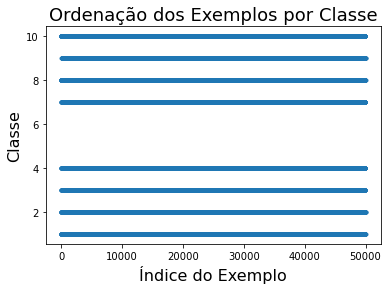

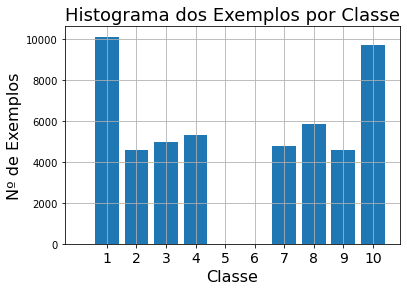

In [18]:
Docs, y = load_Xy('../Dados/imdbFull.p')
print('Número de exemplos :', len(Docs))
print('Classes dos dados  :', np.unique(y))

plt.plot(y, '.')
plt.title('Ordenação dos Exemplos por Classe', fontsize=18)
plt.ylabel('Classe', fontsize=16)
plt.xlabel('Índice do Exemplo', fontsize=16)
#plt.savefig('imagens/ordenacao_dados.png', dpi=300)

hx,b = np.histogram(y, np.arange(0.5, 11, 0.5))
b = (b[:-1]+b[1:])/2

plt.show()
plt.title('Histograma dos Exemplos por Classe', fontsize=18)
plt.ylabel('Nº de Exemplos', fontsize=16)
plt.xlabel('Classe', fontsize=16)

plt.bar(b-0.25, hx)
plt.xticks(np.arange(1,11,1), fontsize=14)
plt.grid()

In [19]:
#Substituir mudanças de linha
Docs = [doc.replace('<br />', ' ') for doc in Docs]
#Remover tudo o que não sejam caracteres do alfabeto
Docs = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs]

## Stemmers (Snowball Stemmer)

In [20]:
'Foi executado uma vez'
# stemFunc = SnowballStemmer(language='english')
# Docs2 = [' '.join([stemFunc.stem(w) for w in d.split()]) for d in Docs]

# imdb_snowball = {'Docs' : Docs2, 'y':y}
# pickle.dump(imdb_snowball, open(stemmed_data_path, 'wb'))
imdb_snowball = pickle.load(open(stemmed_data_path, 'rb'))
print(imdb_snowball.keys())

dict_keys(['Docs', 'y'])


In [21]:
#2, 3 e 4
patterns = [r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b']
min_dfs = [2,3,4,5]
'Foi executado uma vez'
# tfidfs = np.array([len(TfidfVectorizer(min_df=i, token_pattern=j,ngram_range=(1,1)).fit(Docs).get_feature_names()) for i in min_dfs for j in patterns]).reshape((4,3))

# tok = {'tokens' : tfidfs}
# pickle.dump(tok, open(tok_path, 'wb'))
tfidfs = pickle.load(open(tok_path, 'rb'))['tokens']
print(tfidfs)

FileNotFoundError: [Errno 2] No such file or directory: 'Imagens/toks_min_df_tp_on_size.p'

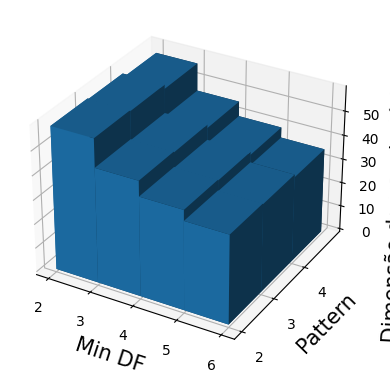

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(121, projection='3d')

_x = np.array(min_dfs)
_y = np.array([2,3,4])
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = tfidfs[x-2, y-2]/1000
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('')
ax1.set_xlabel('Min DF', fontsize=15)
ax1.set_ylabel('Pattern', fontsize=15)
ax1.set_yticks([2,3,4])
ax1.set_zlabel('Dimensão do vocabulário (milhares)', fontsize=15)    
plt.show()

## Binário - Discriminante Logístico

### Função auxiliar

#### Função que retorna os scores do Classifier

In [ ]:
def get_scores_lr(X1Train, X1V, X2, y1Train, y1V, y2, penalty, C, mc='ovr'):
    lr = LogisticRegression(penalty= penalty, solver='liblinear',C = C, max_iter=5000, tol=1e-2,multi_class=mc).fit(X1Train,y1Train)
    
    scTrain     = lr.score(X1Train,y1Train)*100
    scValidated = lr.score(X1V,y1V)*100
    scSA        = scValidated - (scTrain- scValidated)
    scTest      = lr.score(X2,y2)*100
    
    scores = np.array([scTrain,scValidated,scSA,scTest])

    #show Confusion Matrix

    y2e = lr.predict(X2)
    n_erros = np.sum(y2 != y2e)
    CM = confusion_matrix(y2,y2e)
    par = (penalty, C)

    return scores, CM, n_erros, par

### Testar Binário

In [ ]:
D = pickle.load(open(stemmed_data_path,'rb'))

X = D['Docs']
y = D['y']

y[y < 5] = 0
y[y > 6] = 1

ngram_ranges   = [(1,1), (1,2), (1,3)]

In [ ]:
'Foi executado uma vez'
# X1, X2, y1, y2 = train_test_split(X,y,test_size=1/4,stratify=y)
# X1Train, X1V, y1Train, y1V = train_test_split(X1, y1, test_size=1/3,stratify=y1)

# dados = {'X1': X1, 'X2': X2, 'y1': y1, 'y2': y2, 'X1Train': X1Train, 'X1V': X1V, 'y1Train': y1Train, 'y1V': y1V}
# pickle.dump(dados, open(dados_bin_path, 'wb'))

# tfidf_parameters = np.array([(TfidfVectorizer(min_df=i, token_pattern= j, ngram_range=k).fit(X1Train),(i,j,k)) for i in min_dfs for j in patterns for k in ngram_ranges])

# tfidf      = np.array([tfidf_parameters[i][0] for i in range(len(tfidf_parameters))])
# parameters = np.array([tfidf_parameters[i][1] for i in range(len(tfidf_parameters))])


# TF_model = {'tfidf' : tfidf, 'parameters' : parameters}
# pickle.dump(TF_model, open(tfidf_bin_path, 'wb'))

'Foi executado uma vez'

In [ ]:
X1 = pickle.load(open(dados_bin_path, 'rb'))['X1']
X1Train = pickle.load(open(dados_bin_path, 'rb'))['X1Train']
X1V = pickle.load(open(dados_bin_path, 'rb'))['X1V']
X2 = pickle.load(open(dados_bin_path, 'rb'))['X2']

tfidf = pickle.load(open(tfidf_bin_path, 'rb'))['tfidf']
parameters = pickle.load(open(tfidf_bin_path, 'rb'))['parameters'] # os parameters tem [min_df, pattern, ngram]

In [ ]:
'Foi executado uma vez'
# X1s      = np.array([i.transform(X1) for i in tfidf])
# X1Trains = np.array([i.transform(X1Train) for i in tfidf])
# X1Vs     = np.array([i.transform(X1V) for i in tfidf])
# X2s      = np.array([i.transform(X2) for i in tfidf])

# dados = {'X1s' : X1s,'X1Trains' : X1Trains, 'X1Vs' : X1Vs, 'X2s' : X2s}
# pickle.dump(dados, open(arrays_dados_bin_path, 'wb'))

'Foi executado uma vez'

In [ ]:
X1s      = pickle.load(open(arrays_dados_bin_path, 'rb'))['X1s']
X1Trains = pickle.load(open(arrays_dados_bin_path, 'rb'))['X1Trains']
X1Vs     = pickle.load(open(arrays_dados_bin_path, 'rb'))['X1Vs']
X2s      = pickle.load(open(arrays_dados_bin_path, 'rb'))['X2s']

In [ ]:
y1Train = pickle.load(open(dados_bin_path, 'rb'))['y1Train']
y1V     = pickle.load(open(dados_bin_path, 'rb'))['y1V']
y1      = pickle.load(open(dados_bin_path, 'rb'))['y1']
y2      = pickle.load(open(dados_bin_path, 'rb'))['y2']

In [ ]:
penaltys = ['l1', 'l2']
Cs = [0.01, 0.1, 1,  5]

In [ ]:
indice = 0
best_scores = []
par = []
for l in range(len(tfidf)):
    scores_ps_cs = np.array([get_scores_lr(X1Trains[l], X1Vs[l], X2s[l], y1Train, y1V, y2, 'l1', j)[0][3]   for j in Cs])  
    par_ps_cs    = np.array([get_scores_lr(X1Trains[l], X1Vs[l], X2s[l], y1Train, y1V, y2, 'l1', j)[3][1]   for j in Cs]) 
    
    best_scores.append(scores_ps_cs)
    par.append(par_ps_cs)

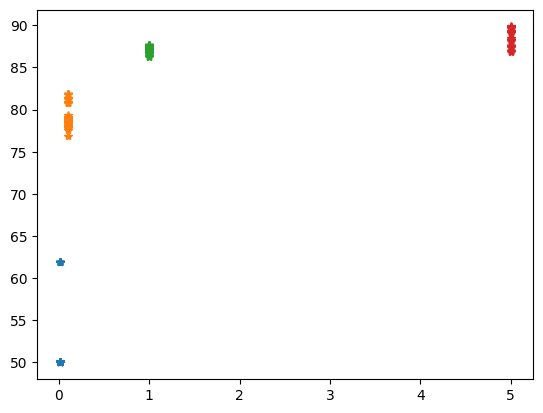

In [ ]:
plt.plot(par, best_scores,'*')